In [89]:
from __future__ import print_function
from pixell import enmap,utils, reproject, enplot
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import urllib.request
from astropy.table import QTable
import astropy.units as u
from astropy.io import fits
import csv
import yaml
%matplotlib inline

In [39]:
def s18dStack(ras, decs, data, width = 20.):
        stack = 0
        divisor = 0
        for i in range(len(ras)):
                path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'
                tileName = tileFinder(ras[i], decs[i], data)
                
                if tileName is None: continue
                    
                tile = enmap.read_map(path+tileName+'/Arnaud_M2e14_z0p4#'+tileName+'_filteredMap.fits')
                stamp = reproject.postage_stamp(tile, ras[i], decs[i], width, 0.5)
                
                try: 
                    stack += stamp[0]
                except:
                    print(tileName)
                    print(tile)
                    print(stamp)
                    
                divisor += 1
        
        try:
            stack /= divisor
        except: 
            print("Error: no items in stack")
            return None, None
        print("Number in stack: {}".format(divisor))
        return stack, divisor

In [40]:
def s18dStacker(catalog, r_low, r_high, data, remove_act = True):
    ra = catalog[1].data['RADeg']
    dec = catalog[1].data['decDeg']
    ra, dec = np.array(ra), np.array(dec)
    rich = catalog[1].data['Rich']

    in_act = ['MOO J0018+0000','MOO J0019+0209','MOO J0028-1005','MOO J0048+1757','MOO J0101+0030','MOO J0102+0201','MOO J0105+1324','MOO J0105-1839','MOO J0120-0304','MOO J0125-0802','MOO J0129-1640','MOO J0132+0329','MOO J0136-0959','MOO J0208-0935','MOO J0234-0107','MOO J0239-1035','MOO J0300+0124','MOO J0303+1857','MOO J0308-2915','MOO J0353+0832','MOO J0448-1705','MOO J0846+1504','MOO J0934+1751','MOO J0936+0337','MOO J1014+0038','MOO J1029+0017','MOO J1048+0743','MOO J1053+1052','MOO J1140+1522','MOO J1142+1346','MOO J1142+1527','MOO J1149+0921','MOO J1204+1525','MOO J1208+0501','MOO J1241+0011','MOO J1254+0948','MOO J1310+1707','MOO J1322-0228','MOO J1346-0142','MOO J1354+1329','MOO J1355+1606','MOO J1414+0227','MOO J1418+0723','MOO J1424-0141','MOO J1454+0628','MOO J1455+0439','MOO J1514+1346','MOO J1521+0452','MOO J1525+1541','MOO J1536+0953','MOO J1620+1340','MOO J2146-0320','MOO J2205-2955','MOO J2231+1130','MOO J2235+1320','MOO J2316+0920','MOO J2319-1856','MOO J2358+1836']

    names = catalog[1].data['name']
    if remove_act:
        flags = [True]*len(ra)

        for i, name in enumerate(names):
            if name in in_act:
                flags[i] = False

        print("Number before confirmed removal: {}".format(len(ra)))
        ra = ra[flags]
        dec = dec[flags]
        rich = rich[flags]
        print("Number after confirmed removal: {}".format(len(ra)))

    print("Number above cut: {}".format(len(ra)))    
        
    cut = np.where((r_low<np.array(rich)) & (np.array(rich)<=r_high))[0]
    
    cut_ra, cut_dec = ra[cut], dec[cut]
    
    stack, num = s18dStack(cut_ra, cut_dec, data)
    print(num)
    
    if type(stack) == type(None):
        print("Error: No objects in stack")
        return None, None
    out, cen, cen_d, out_d = 0,0,0,0

    for i in range(len(stack[0])):
        for j in range(len(stack[0])):
            if (28<i<32) & (28<j<32):
                cen += stack[i][j]
                cen_d += 1
            else:
                out += stack[i][j]
                out_d += 1

    plot = plt.imshow(stack, extent = [-20,20,-20,20])
    plt.scatter(0,0, marker = '+', color = 'r')
    plt.colorbar(plot, format='%.0e')
    plt.title("ACT S18 dStack on MaDCoWS w/ {}=>Richness>{}\n Total in stack: {}".format(r_high, r_low, num))
    plt.savefig("./plots/mdcw_cut_rich_{}_{}_stack_s18d_y.png".format(r_low,r_high))
    plt.show()
    plt.close()
    
    enmap.write_map('./stacks/mdcw_cut_rich_{}_{}_stack_s18d_y.fits'.format(r_low,r_high), stack)
    
    return cen/cen_d, out/out_d

In [41]:
with open('/scratch/r/rbond/jorlo/S18d_202006/selFn/tileDefinitions.yml') as f:
    
    s18d = yaml.load(f)


In [105]:
def tileFinder(ra, dec, data):
    #Given an RA and Dec in deg, find the S18d tile containing that RA and Dec
    for i, tile in enumerate(data):
        box = tile['RADecSection']
        if box[0]<=ra<=box[1] and box[2]<=dec<= box[3]:
            return tile['tileName']
    return None

        

In [106]:
def s18dStamp(ra, dec, data, name, width = 0.5, write = True):
    #Find tile corresponding to RA, Dec
    path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'
    tileName = tileFinder(ra, dec, data)
    if tileName == None: return None
    tile = enmap.read_map(path+tileName+'/Arnaud_M2e14_z0p4#'+tileName+'_filteredMap.fits')
    
    stamp = reproject.postage_stamp(tile, ra, dec, width*60, 0.5)
    if write:
        plt.imshow(stamp[0])
        plt.show()
        #Return map
        enmap.write_map('./for_tony/{}.fits'.format(name), stamp)
    return stamp


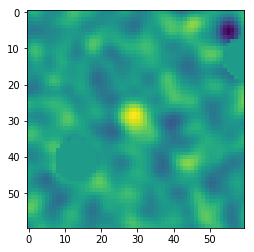

ndmap([[[  9.80398972e-06   1.73799892e-05   1.85696170e-05 ...,   6.11901326e-06
     1.66524432e-05   2.32589075e-05]
  [  1.10852291e-06   7.62105327e-06   9.40987458e-06 ...,  -6.59058591e-06
     1.19910750e-05   2.57270040e-05]
  [ -1.05595948e-05  -6.78959651e-06  -4.30786509e-06 ...,  -2.77291872e-05
     4.56373229e-08   2.29454934e-05]
  ..., 
  [  1.04607247e-05   1.21112545e-05   1.17600836e-05 ...,  -2.87630832e-05
    -1.14743024e-05   8.54080419e-06]
  [ -6.02822710e-07   5.04843392e-06   1.04557595e-05 ...,  -2.96166217e-05
    -1.33169333e-05   5.68900806e-06]
  [ -6.32749355e-06   2.87510616e-06   1.23169286e-05 ...,  -2.62603018e-05
    -1.29380687e-05   2.26807003e-06]]],tan:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[30.5,30.5]})

In [107]:
s18dStamp(303.1103611788376,-56.83093699573238, s18d, 'ACT-CL_J2012.4-5649')

Number before confirmed removal: 2839
Number after confirmed removal: 2781
3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 1403
4.32912635195e-06
-2.03078256193e-08


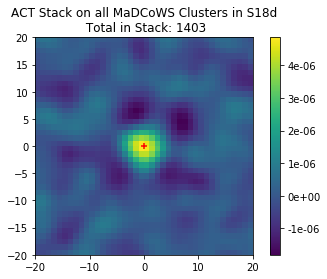

In [34]:
#Try stacking MDCW clusters on S18d

mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

mdcw_ra = mdcw_catalog[1].data['RADeg']
mdcw_dec =mdcw_catalog[1].data['decDeg']
mdcw_ra, mdcw_dec = np.array(mdcw_ra), np.array(mdcw_dec)
mdcw_rich = mdcw_catalog[1].data['Rich']

in_act = ['MOO J0018+0000','MOO J0019+0209','MOO J0028-1005','MOO J0048+1757','MOO J0101+0030','MOO J0102+0201','MOO J0105+1324','MOO J0105-1839','MOO J0120-0304','MOO J0125-0802','MOO J0129-1640','MOO J0132+0329','MOO J0136-0959','MOO J0208-0935','MOO J0234-0107','MOO J0239-1035','MOO J0300+0124','MOO J0303+1857','MOO J0308-2915','MOO J0353+0832','MOO J0448-1705','MOO J0846+1504','MOO J0934+1751','MOO J0936+0337','MOO J1014+0038','MOO J1029+0017','MOO J1048+0743','MOO J1053+1052','MOO J1140+1522','MOO J1142+1346','MOO J1142+1527','MOO J1149+0921','MOO J1204+1525','MOO J1208+0501','MOO J1241+0011','MOO J1254+0948','MOO J1310+1707','MOO J1322-0228','MOO J1346-0142','MOO J1354+1329','MOO J1355+1606','MOO J1414+0227','MOO J1418+0723','MOO J1424-0141','MOO J1454+0628','MOO J1455+0439','MOO J1514+1346','MOO J1521+0452','MOO J1525+1541','MOO J1536+0953','MOO J1620+1340','MOO J2146-0320','MOO J2205-2955','MOO J2231+1130','MOO J2235+1320','MOO J2316+0920','MOO J2319-1856','MOO J2358+1836']

names = mdcw_catalog[1].data['name']

flags = [True]*len(mdcw_ra)

for i, name in enumerate(names):
    #print(name)
    if name in in_act:
        #print(i)
        flags[i] = False

print("Number before confirmed removal: {}".format(len(mdcw_ra)))
mdcw_ra = mdcw_ra[flags]
mdcw_dec = mdcw_dec[flags]
mdcw_rich = mdcw_rich[flags]
print("Number after confirmed removal: {}".format(len(mdcw_ra)))

s18d_stack, stack_num = s18dStack(mdcw_ra, mdcw_dec, s18d)

out, cen, cen_d, out_d = 0,0,0,0

for i in range(len(s18d_stack[0])):
    for j in range(len(s18d_stack[0])):
        if (18<i<22) & (18<j<22):
            cen += s18d_stack[i][j]
            cen_d += 1
        else:
            out += s18d_stack[i][j]
            out_d += 1
print(cen/cen_d)
print(out/out_d)


plot = plt.imshow(s18d_stack, extent = [-20,20,-20,20])
plt.scatter(0,0, marker = '+', color = 'r')
plt.colorbar(plot, format='%.0e')
plt.title("ACT Stack on all MaDCoWS Clusters in S18d\n Total in Stack: {}".format(stack_num))
plt.savefig("mdcw_stack_s18d_y.png")
plt.show()
plt.close()

Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Number in stack: 28
28


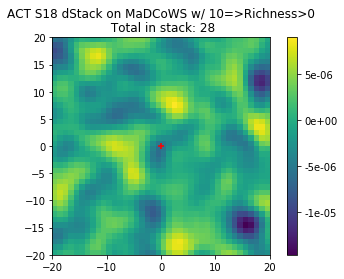

For richness bin 0 to 10 cen/cen_d = 7.965433740571284e-07, out/out_d = -1.0124021479041478e-07, s/n = -7.86785543379293
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Number in stack: 176
176


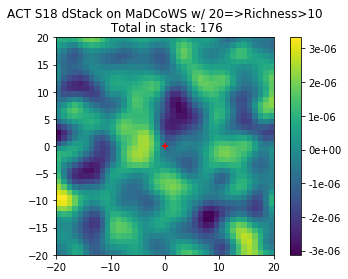

For richness bin 10 to 20 cen/cen_d = -1.0991249271842603e-06, out/out_d = -8.502609605815506e-09, s/n = 129.26912773138434
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in sta

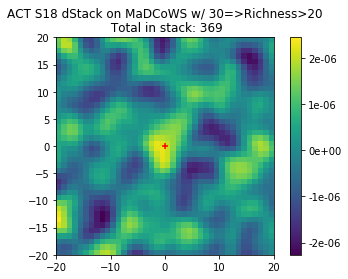

For richness bin 20 to 30 cen/cen_d = -2.144008325748536e-08, out/out_d = 1.3150340209526033e-08, s/n = -1.630382401966626
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Number in stack: 219
219


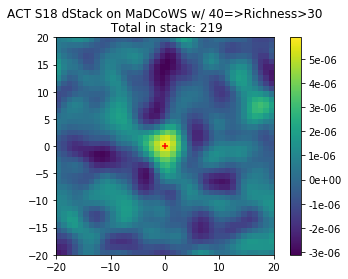

For richness bin 30 to 40 cen/cen_d = 7.248352135427849e-07, out/out_d = -4.008209405900902e-08, s/n = -18.083766094547848
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Number in stack: 72
72


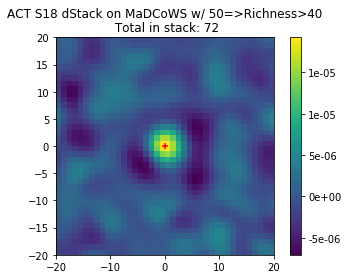

For richness bin 40 to 50 cen/cen_d = 7.991409380250025e-07, out/out_d = -1.0674496822081851e-07, s/n = -7.48645066221628
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Number in stack: 25
25


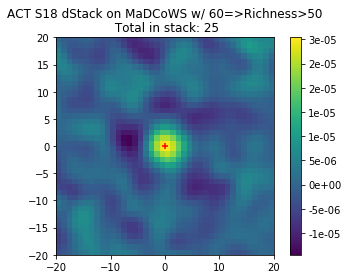

For richness bin 50 to 60 cen/cen_d = -3.7468555010360293e-06, out/out_d = 5.121059504469371e-08, s/n = -73.16563101377724
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Number in stack: 5
5


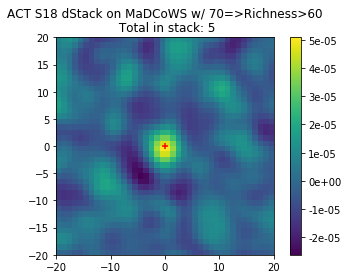

For richness bin 60 to 70 cen/cen_d = 3.235248755079596e-06, out/out_d = -1.7371014596297377e-07, s/n = -18.6244087076479
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Error: no items in stack
None
Error: No objects in stack
For  richness bin 70 to 80, no items in stack
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Error: no items in stack
None
Error: No objects in stack
For  richness bin 80 to 90, no items in stack
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781
Error: no items in stack
None
Error: No objects in stack
For  richness bin 90 to 100, no items in stack


In [124]:
for i in range(0, 100, 10):
    a,b = s18dStacker(mdcw_catalog, i, i+10, s18d)
    if a == None:
        print("For  richness bin {} to {}, no items in stack".format(i, i+10))
        continue
    print("For richness bin {} to {} cen/cen_d = {}, out/out_d = {}, s/n = {}".format(i, i+10, a, b, a/b))



Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781


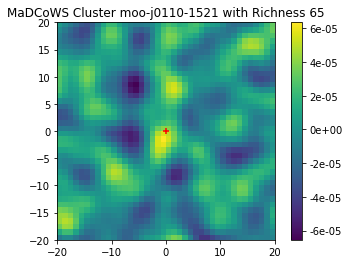

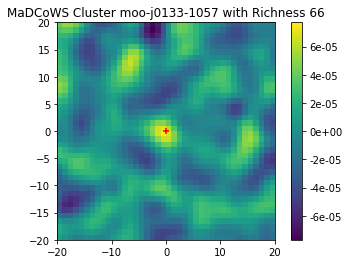

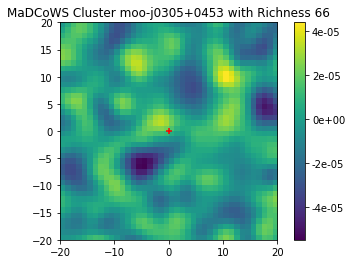

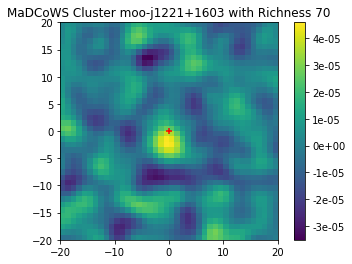

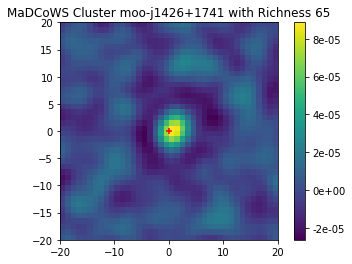

In [122]:
ra = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
dec = mdcw_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
rich = mdcw_catalog[1].data['Rich']

path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'

in_act = ['MOO J0018+0000','MOO J0019+0209','MOO J0028-1005','MOO J0048+1757','MOO J0101+0030','MOO J0102+0201','MOO J0105+1324','MOO J0105-1839','MOO J0120-0304','MOO J0125-0802','MOO J0129-1640','MOO J0132+0329','MOO J0136-0959','MOO J0208-0935','MOO J0234-0107','MOO J0239-1035','MOO J0300+0124','MOO J0303+1857','MOO J0308-2915','MOO J0353+0832','MOO J0448-1705','MOO J0846+1504','MOO J0934+1751','MOO J0936+0337','MOO J1014+0038','MOO J1029+0017','MOO J1048+0743','MOO J1053+1052','MOO J1140+1522','MOO J1142+1346','MOO J1142+1527','MOO J1149+0921','MOO J1204+1525','MOO J1208+0501','MOO J1241+0011','MOO J1254+0948','MOO J1310+1707','MOO J1322-0228','MOO J1346-0142','MOO J1354+1329','MOO J1355+1606','MOO J1414+0227','MOO J1418+0723','MOO J1424-0141','MOO J1454+0628','MOO J1455+0439','MOO J1514+1346','MOO J1521+0452','MOO J1525+1541','MOO J1536+0953','MOO J1620+1340','MOO J2146-0320','MOO J2205-2955','MOO J2231+1130','MOO J2235+1320','MOO J2316+0920','MOO J2319-1856','MOO J2358+1836']

names = mdcw_catalog[1].data['name']
flags = [True]*len(ra)

for i, name in enumerate(names):
    if name in in_act:
        flags[i] = False

print("Number before confirmed removal: {}".format(len(ra)))
ra = ra[flags]
dec = dec[flags]
rich = rich[flags]
names = names[flags]
print("Number after confirmed removal: {}".format(len(ra)))

print("Number above cut: {}".format(len(ra)))    

cut = np.where((60<np.array(rich)) & (np.array(rich)<1000))[0]
cut_ra, cut_dec, cut_names, cut_rich = ra[cut], dec[cut], names[cut], rich[cut]

for i in range(len(cut_ra)):
    tileName = tileFinder(cut_ra[i], cut_dec[i], s18d)
    if tileName is None: continue
    tile = enmap.read_map(path+tileName+'/Arnaud_M2e14_z0p4#'+tileName+'_filteredMap.fits')
    
    name = cut_names[i]
    name = name.replace(' ', '-').lower()
    
    stamp = reproject.postage_stamp(tile, cut_ra[i], cut_dec[i], 20., 0.5)

    
    plot = plt.imshow(stamp[0], extent = [-20,20,-20,20])
    plt.scatter(0,0, marker = '+', color = 'r')
    plt.colorbar(plot, format='%.0e')
    plt.title("MaDCoWS Cluster {} with Richness {}".format(name, cut_rich[i]))
    plt.savefig(name + "_s18d_y.png")
    plt.show()
    plt.close()

Number before confirmed removal: 2839
Number after confirmed removal: 58
Number in stack: 55


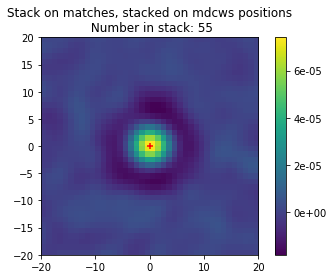

In [137]:
#Stack on MaDCoWS and ACT centers for known cross matches.
#Stacking on MaDCoWS positions
ra = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
dec = mdcw_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
rich = mdcw_catalog[1].data['Rich']

path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'

in_act = ['MOO J0018+0000','MOO J0019+0209','MOO J0028-1005','MOO J0048+1757','MOO J0101+0030','MOO J0102+0201','MOO J0105+1324','MOO J0105-1839','MOO J0120-0304','MOO J0125-0802','MOO J0129-1640','MOO J0132+0329','MOO J0136-0959','MOO J0208-0935','MOO J0234-0107','MOO J0239-1035','MOO J0300+0124','MOO J0303+1857','MOO J0308-2915','MOO J0353+0832','MOO J0448-1705','MOO J0846+1504','MOO J0934+1751','MOO J0936+0337','MOO J1014+0038','MOO J1029+0017','MOO J1048+0743','MOO J1053+1052','MOO J1140+1522','MOO J1142+1346','MOO J1142+1527','MOO J1149+0921','MOO J1204+1525','MOO J1208+0501','MOO J1241+0011','MOO J1254+0948','MOO J1310+1707','MOO J1322-0228','MOO J1346-0142','MOO J1354+1329','MOO J1355+1606','MOO J1414+0227','MOO J1418+0723','MOO J1424-0141','MOO J1454+0628','MOO J1455+0439','MOO J1514+1346','MOO J1521+0452','MOO J1525+1541','MOO J1536+0953','MOO J1620+1340','MOO J2146-0320','MOO J2205-2955','MOO J2231+1130','MOO J2235+1320','MOO J2316+0920','MOO J2319-1856','MOO J2358+1836']

names = mdcw_catalog[1].data['name']
flags = [True]*len(ra)

for i, name in enumerate(names):
    if name not in in_act:
        flags[i] = False

print("Number before confirmed removal: {}".format(len(ra)))
ra = ra[flags]
dec = dec[flags]
rich = rich[flags]
names = names[flags]
print("Number after confirmed removal: {}".format(len(ra)))

s18d_stack, stack_num = s18dStack(ra, dec, s18d)

"""
out, cen, cen_d, out_d = 0,0,0,0

for i in range(len(s18d_stack[0])):
    for j in range(len(s18d_stack[0])):
        if (28<i<32) & (28<j<32):
            cen += s18d_stack[i][j]
            cen_d += 1
        else:
            out += s18d_stack[i][j]
            out_d += 1
print(cen/cen_d)
print(out/out_d)
"""

plot = plt.imshow(s18d_stack, extent = [-20,20,-20,20])
plt.scatter(0,0, marker = '+', color = 'r')
plt.colorbar(plot, format='%.0e')
plt.title('Stack on matches, stacked on mdcws positions\n Number in stack: {}'.format(stack_num))
plt.savefig("plots/stack_mdcw_pos.png")
plt.show()
plt.close()

Number before confirmed removal: 4173
Number after confirmed removal: 49
Number in stack: 46


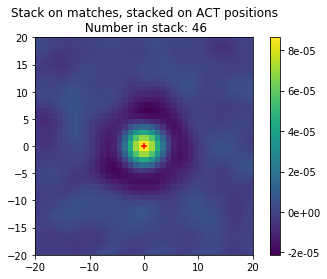

In [139]:
t = QTable.read('madcows/AdvACT_S18Clusters_v1.0-beta.fits')

ra = t['RADeg']
flags = t['MaDCoWS']
dec = t['decDeg']
ra, dec = np.array(ra), np.array(dec)

path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'

in_act = ['ACT-CL J0019.0-0000', 'ACT-CL J0019.8+0210', 'ACT-CL J0028.1-1005', 'ACT-CL J0048.4+1757', 'ACT-CL J0101.7+0030', 'ACT-CL J0102.6+0201', 'ACT-CL J0105.5+1323', 'ACT-CL J0105.8-1839', 'ACT-CL J0120.7-0305', 'ACT-CL J0125.3-0802', 'ACT-CL J0129.2-1641', 'ACT-CL J0131.9+0329', 'ACT-CL J0136.0-0959', 'ACT-CL J0208.1-0935', 'ACT-CL J0234.5-0107', 'ACT-CL J0239.6-1036', 'ACT-CL J0300.2+0125', 'ACT-CL J0303.6+1857', 'ACT-CL J0308.1-2915', 'ACT-CL J0353.3+0832', 'ACT-CL J0448.4-1705', 'ACT-CL J0846.6+1504', 'ACT-CL J0934.4+1751', 'ACT-CL J0936.7+0336', 'ACT-CL J1014.1+0038', 'ACT-CL J1029.9+0016', 'ACT-CL J1048.7+0743','ACT-CL J1053.2+1052', 'ACT-CL J1140.1+1523', 'ACT-CL J1142.1+1345', 'ACT-CL J1142.7+1527', 'ACT-CL J1149.4+0921', 'ACT-CL J1205.0+1525', 'ACT-CL J1208.3+0501', 'ACT-CL J1241.0+0010', 'ACT-CL J1254.9+0947', 'ACT-CL J1310.6+1707', 'ACT-CL J1322.9-0227', 'ACT-CL J1346.2-0142', 'ACT-CL J1354.8+1330', 'ACT-CL J1355.8+1607', 'ACT-CL J1414.5+0227', 'ACT-CL J1418.2+0723', 'ACT-CL J1424.9-0141', 'ACT-CL J1454.5+0628', 'ACT-CL J1455.5+0439', 'ACT-CL J1514.7+1346', 'ACT-CL J1521.1+0451', 'ACT-CL J1525.8+1540', 'ACT-CL J1536.5+0954', 'ACT-CL J1620.1+1339', 'ACT-CL J2146.6-0321', 'ACT-CL J2204.9-2955', 'ACT-CL J2231.9+1131', 'ACT-CL J2235.0+1320', 'ACT-CL J2316.2+0920', 'ACT-CL J2319.8-1856', 'ACT-CL J2358.8+1836']

names = t['name']
flags = [True]*len(ra)

for i, name in enumerate(names):
    if name not in in_act:
        flags[i] = False

print("Number before confirmed removal: {}".format(len(ra)))
ra = ra[flags]
dec = dec[flags]
print("Number after confirmed removal: {}".format(len(ra)))

s18d_stack, stack_num = s18dStack(ra, dec, s18d)

"""
out, cen, cen_d, out_d = 0,0,0,0

for i in range(len(s18d_stack[0])):
    for j in range(len(s18d_stack[0])):
        if (28<i<32) & (28<j<32):
            cen += s18d_stack[i][j]
            cen_d += 1
        else:
            out += s18d_stack[i][j]
            out_d += 1
print(cen/cen_d)
print(out/out_d)
"""

plot = plt.imshow(s18d_stack, extent = [-20,20,-20,20])
plt.scatter(0,0, marker = '+', color = 'r')
plt.colorbar(plot, format='%.0e')
plt.title('Stack on matches, stacked on ACT positions\n Number in stack: {}'.format(stack_num))
plt.savefig("plots/stack_ACT_pos.png")
plt.show()
plt.close()

In [233]:
#Looking at brightness by richness bin

def richStat(data, catalog, r_low, r_high, bins = 1, save_plot = False):
    ra = catalog[1].data['RADeg']
    names = catalog[1].data['name']
    dec = catalog[1].data['decDeg']
    ra, dec = np.array(ra), np.array(dec)
    rich = catalog[1].data['Rich']
    names = catalog[1].data['name']
    path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'

    cut = np.where((r_low<np.array(rich)) & (np.array(rich)<=r_high))[0]
    cut_ra, cut_dec, cut_names, cut_rich = ra[cut], dec[cut], names[cut], rich[cut]
    
    if bins == 1:
        stack, num = s18dStack(cut_ra, cut_dec, data)

        plot = plt.imshow(stack)
        plt.colorbar(plot, format='%.0e')
        plt.title("ACT S18 dStack on MaDCoWS w/ {}=>Richness>{}\n Total in stack: {}".format(r_high, r_low, num))

        plt.show()
        mean = np.amax(stack[18:22, 18:22])

        brights = []
        for i in range(len(cut_ra)):
            stamp = s18dStamp(cut_ra[i], cut_dec[i], s18d, 'fakename', width = 1/3, write = False)
            if stamp is None: continue
            brights.append(np.amax(stamp[0][18:22, 18:22]))

            if save_plot:
                plot = plt.imshow(stamp[0], extent = [-20,20,-20,20])
                plt.scatter(0,0, marker = '+', color = 'r')
                plt.colorbar(plot, format='%.0e')
                plt.title('Cluster {}, {}th Percentile'.format(cut_names[i], round(100/(bin))))

                plt.savefig('plots/indv_clusters/' + str(cut_names[i]) + '.png')
                plt.close()

        var = np.var(brights)
        #print(brights)
    
        return mean, var
    else:
        percs = [r_low]
        means = []
        varies =[]
        #NOTE: Percentiles are in terms of the full MaDCoWS catalog: these will not neccesarily be exactly the
        #percentiles for the subset of the clusters that are in the s18d footprint
        for i in range(bins):
            perc = np.percentile(cut_rich, (i+1)*100/(bins))
            percs.append(perc)
        for i in range(bins):
            flags2 = np.where((percs[i] < cut_rich) & (cut_rich <= percs[i+1]))[0]
            cut_ra2, cut_dec2, cut_names2, cut_rich2 = cut_ra[flags2], cut_dec[flags2], cut_names[flags2], cut_rich[flags2]
        
            stack, num = s18dStack(cut_ra2, cut_dec2, data)

            plot = plt.imshow(stack, extent = [-20,20,-20,20])
            plt.colorbar(plot, format='%.0e')
            plt.scatter(0,0, marker = '+', color = 'r')
            
            plt.title("ACT S18d Stack on MaDCoWS w/ {}=>Richness>{}\n {} to {}th percentile, total in stack: {}".format(r_high, r_low, int((i)*100/(bins)), int((i+1)*100/(bins)), num))
            plt.savefig('plots/rich_bins/rich_bin_{}_{}_{}_rich_perc.png'.format(r_low, r_high, int((i+1)*100/(bins))))
            plt.show()
            mean = np.amax(stack[18:22, 18:22])

            brights = []
            for i in range(len(cut_ra2)):
                stamp = s18dStamp(cut_ra2[i], cut_dec2[i], s18d, 'fakename', width = 1/3, write = False)
                if stamp is None: continue
                brights.append(np.amax(stamp[0][18:22, 18:22]))

                if save_plot:
                    plot = plt.imshow(stamp[0], extent = [-20,20,-20,20])
                    plt.scatter(0,0, marker = '+', color = 'r')
                    plt.colorbar(plot, format='%.0e')
                    plt.title('Cluster {}, {}th Richness Percentile'.format(cut_names2[i], int((i+1)*100/(bins))))
                    
                    plt.savefig('plots/indv_clusters/' + str(cut_names2[i]) + str(int((i+1)*100/(bins))) + '.png')
                    plt.close()

            var = np.var(brights)
            varies.append(var)
            means.append(mean)
            
        return means, varies
    

Number in stack: 28


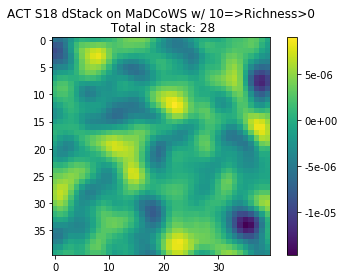

Number in stack: 178


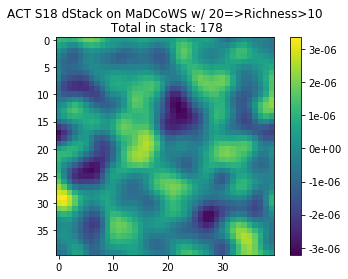

3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 376


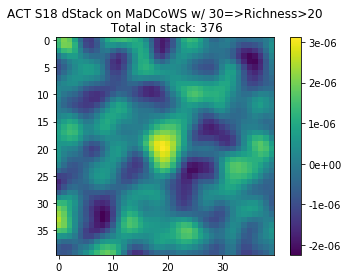

Number in stack: 233


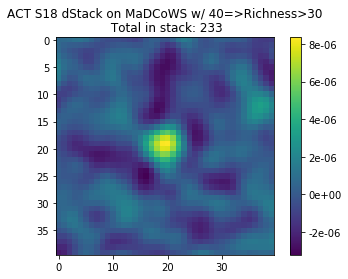

Number in stack: 89


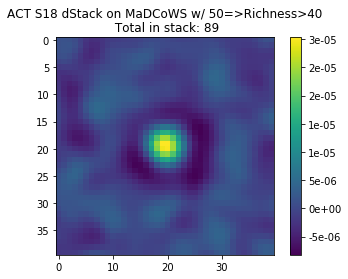

Number in stack: 33


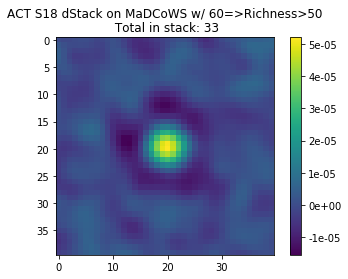

Number in stack: 7


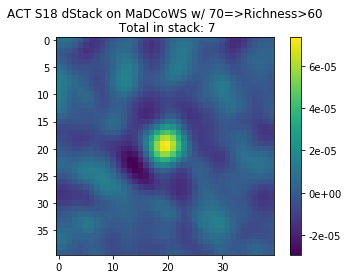

In [237]:
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

means = []
for i in range(0, 70, 10):
    mean, ignore = richStat(s18d, mdcw_catalog, i, i + 10)
    means.append(mean)

Number in stack: 12


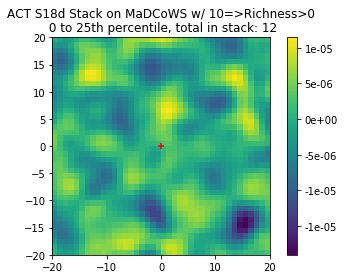

Number in stack: 1


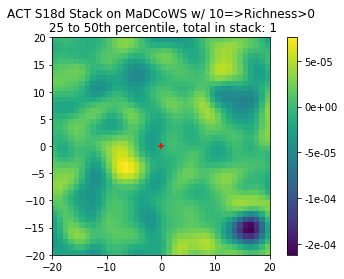

Number in stack: 9


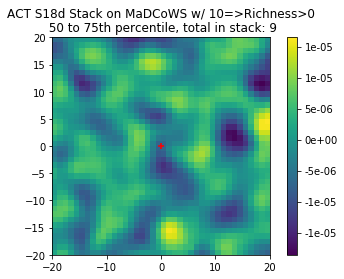

Number in stack: 6


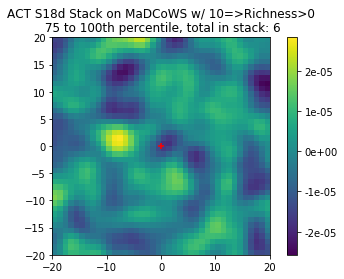

Number in stack: 62


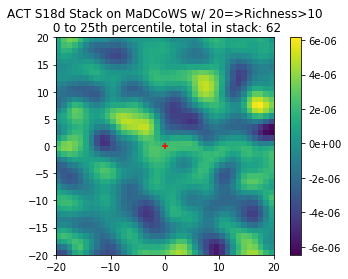

Number in stack: 46


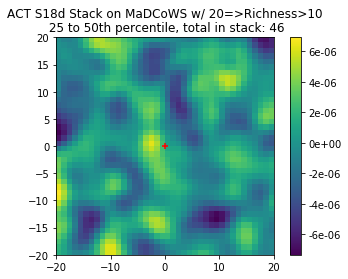

Number in stack: 40


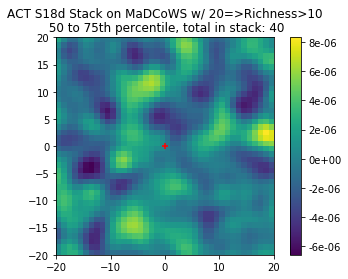

Number in stack: 30


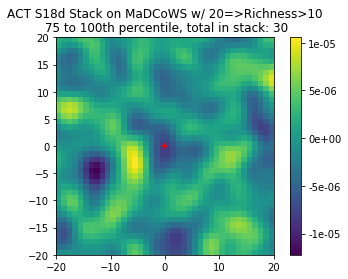

Number in stack: 115


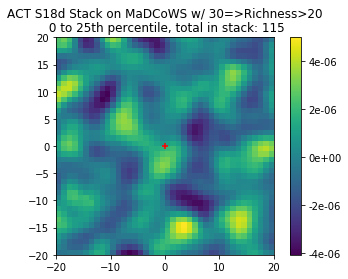

Number in stack: 71


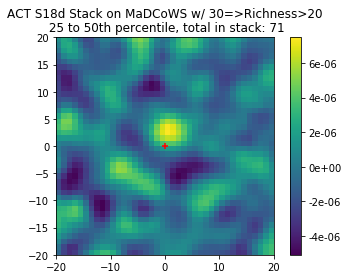

3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 115


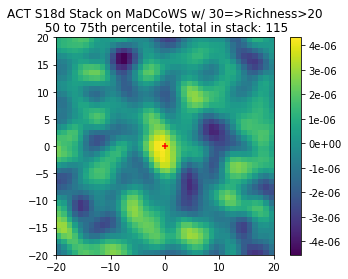

Number in stack: 75


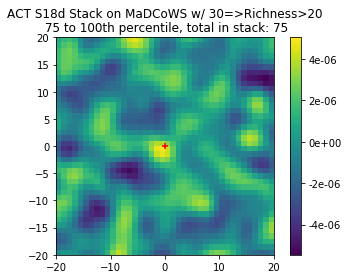

Number in stack: 83


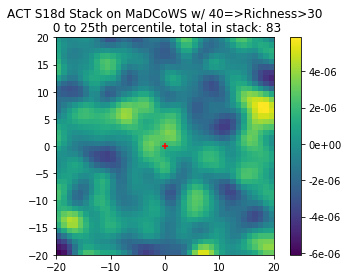

Number in stack: 56


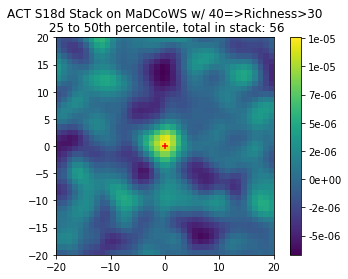

Number in stack: 54


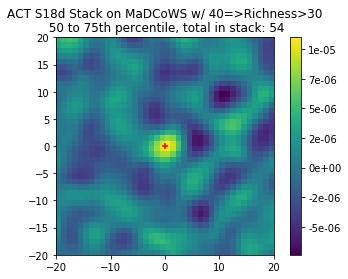

Number in stack: 40


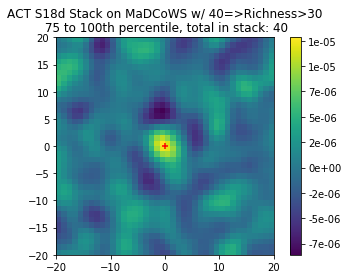

Number in stack: 31


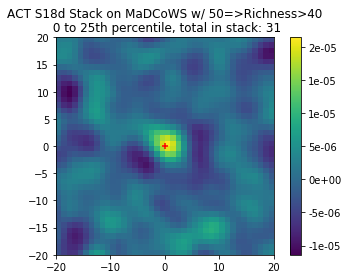

Number in stack: 20


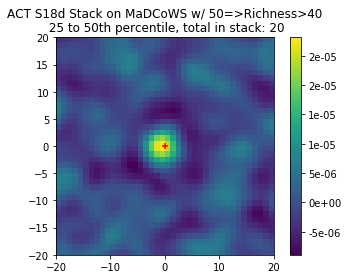

Number in stack: 20


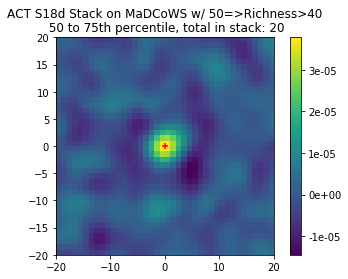

Number in stack: 18


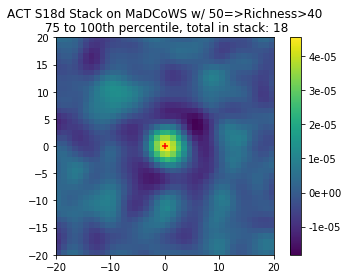

Number in stack: 15


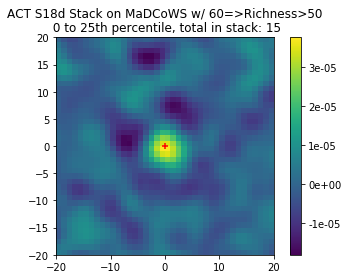

Number in stack: 5


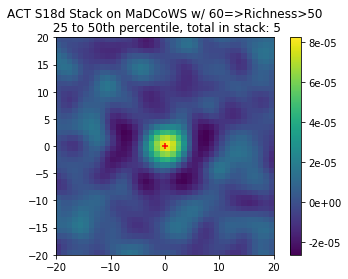

Number in stack: 7


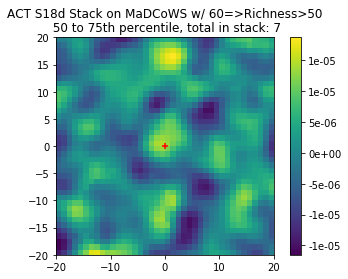

Number in stack: 6


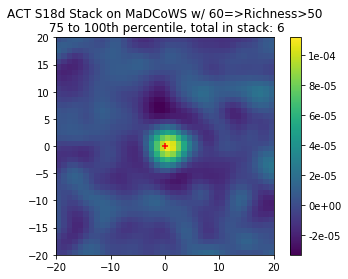

In [239]:
long_means =[]
for i in range(0, 60, 10):
    mean, ignore = richStat(s18d, mdcw_catalog, i, i+10, bins = 4, save_plot = True)
    long_means.append(mean)

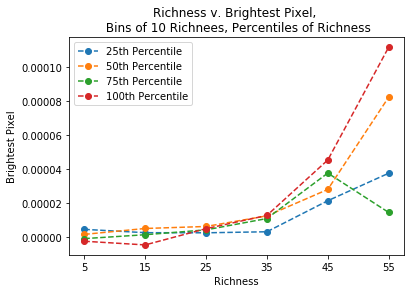

In [216]:

temp = np.transpose(long_means)
for i in range(len(temp)):
    plt.plot( range(5,65, 10),temp[i], label = str(int((i+1)*100/(len(temp))))+'th Percentile', marker='o',linestyle="dashed")
plt.legend()
plt.xlabel('Richness')
plt.xticks(range(5, 65, 10))
plt.ylabel('Brightest Pixel')
plt.title('Richness v. Brightest Pixel, \n Bins of 10 Richnees, Percentiles of Richness')
plt.savefig('richness-brightness.png')
plt.show()

In [225]:
#Now still binning in Richness but in percentiles of brightest pixel (center 4x4 pixels)
def richStatBright(data, catalog, r_low, r_high, bins = 1, save_plot = False):
    ra = catalog[1].data['RADeg']
    names = catalog[1].data['name']
    dec = catalog[1].data['decDeg']
    ra, dec = np.array(ra), np.array(dec)
    rich = catalog[1].data['Rich']
    names = catalog[1].data['name']
    path = '/scratch/r/rbond/jorlo/S18d_202006/filteredMaps/'

    cut = np.where((r_low<np.array(rich)) & (np.array(rich)<=r_high))[0]
    cut_ra, cut_dec, cut_names, cut_rich = ra[cut], dec[cut], names[cut], rich[cut]
    
    stack, num = s18dStack(cut_ra, cut_dec, data)

    #plot = plt.imshow(stack)
    #plt.colorbar(plot, format='%.0e')
    #plt.title("ACT S18 dStack on MaDCoWS w/ {}=>Richness>{}\n Total in stack: {}".format(r_high, r_low, num))

    #plt.show()
    #mean = np.amax(stack[18:22, 18:22])

    brights = []
    for i in range(len(cut_ra)):
        stamp = s18dStamp(cut_ra[i], cut_dec[i], s18d, 'fakename', width = 1/3, write = False)
        if stamp is None: continue
        brights.append(np.amax(stamp[0][18:22, 18:22]))



    var = np.var(brights)
    
    percs = [0]
    means = []
    #NOTE: Percentiles are in terms of the full MaDCoWS catalog: these will not neccesarily be exactly the
    #percentiles for the subset of the clusters that are in the s18d footprint
    for i in range(bins):
        perc = np.percentile(brights, (i+1)*100/(bins))
        percs.append(perc)
        
    for i in range(bins):
        flag = np.where((percs[i] < np.array(brights)) & (np.array(brights) <= percs[i+1]))[0]

        cut_ra2, cut_dec2, cut_names2 = cut_ra[flag], cut_dec[flag], cut_names[flag]
        
        stack, num = s18dStack(cut_ra2, cut_dec2, data)
        
        plot = plt.imshow(stack, extent = [-20,20,-20,20])
        plt.scatter(0,0, marker = '+', color = 'r')
        plt.colorbar(plot, format='%.0e')
        plt.title("ACT S18d Stack on MaDCoWS w/ {}=>Richness>{}\n {} to {}th brightness percentile, total in stack: {}".format(r_high, r_low, int((i)*100/(bins)), int((i+1)*100/(bins)), num))
        plt.savefig('plots/rich_bins/rich_bin_{}_{}_{}_bright_perc.png'.format(r_low, r_high, int((i+1)*100/(bins))))
        plt.show()
        plt.close()

        means.append(np.amax(stack[18:22, 18:22]))
        
    return means

Number in stack: 28
[ 7 11 12 23]
Number in stack: 3


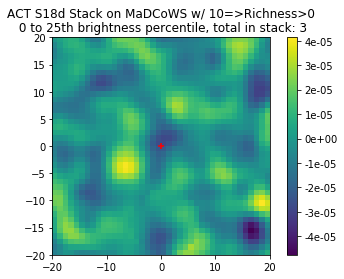

[ 3  6 10 17 22 24 26]
Number in stack: 5


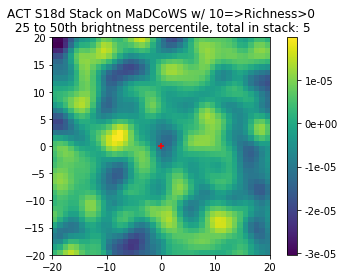

[ 0  1  2  5 16 19 21]
Number in stack: 5


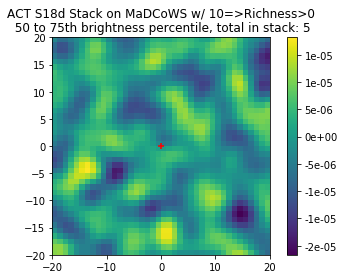

[ 4  8  9 13 14 15 25]
Number in stack: 5


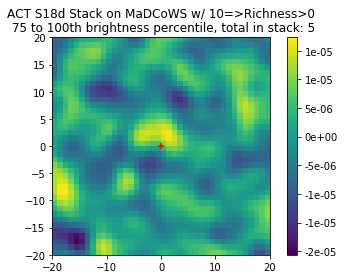

Number in stack: 178
[ 26  46  48  51  58  80  88  95  96 113 155 158 165]
Number in stack: 7


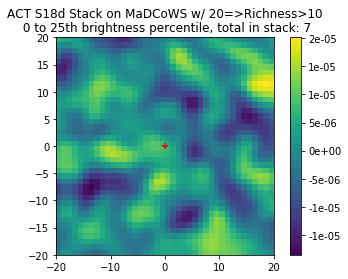

[  1   6  15  16  22  24  25  40  44  45  47  63  65  67  71  84  85  93
  97 102 103 104 107 110 111 114 115 118 121 123 126 127 132 133 141 142
 149 156 159 166 169 170 171 177]
Number in stack: 21


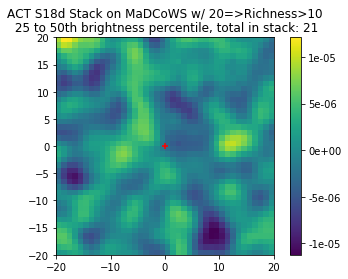

[  7   8  14  18  20  27  29  30  32  34  35  36  37  38  43  52  62  70
  72  75  77  78  79  82  83  87  89  90  91 101 106 108 122 124 125 129
 139 140 148 157 161 163 167 173]
Number in stack: 30


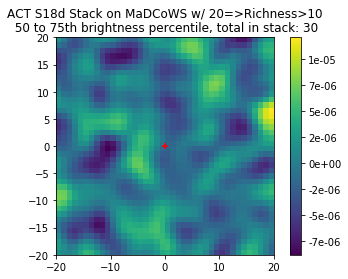

[  3   4   5   9  11  12  13  17  19  21  23  28  31  33  39  50  53  55
  56  57  59  61  66  69  73  74  81  94  98  99 105 120 128 130 134 136
 138 144 145 146 151 152 162 172 176]
Number in stack: 27


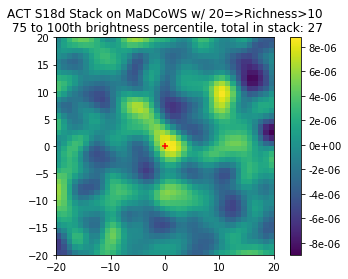

3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -1.09981336e-06 ...,   1.34174376e-06
    9.54024841e-07   5.37281483e-07]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,-153]})
None
Number in stack: 376
[  5  12  14  18  19  23  24  26  29  36  40  44  46  50  51  54  65  69
  74  75  78  88  93  97  99 103 124 154 162 173 177 179 183 185 201 203
 224 229 234 235 236 239 241 245 250 258 259 261 267 271 279 290 296

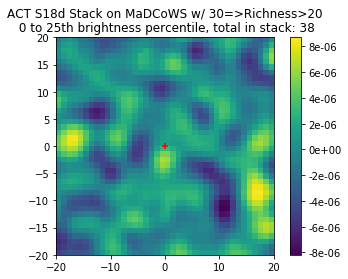

[  0   2   6  15  16  22  25  27  31  32  34  35  41  45  48  49  52  56
  57  58  62  63  71  79  80  82  92 105 106 116 117 119 120 126 127 131
 132 139 142 148 158 160 164 168 169 174 190 191 194 196 199 204 205 208
 212 214 218 219 223 226 228 232 237 240 242 248 249 252 254 257 264 272
 276 278 280 281 282 284 293 295 297 309 318 321 323 325 329 336 349 350
 352 369 370 373]
3_1_0
ndmap([[  3.02442893e-07  -1.44052551e-07  -4.99107357e-07 ...,   1.68750295e-06
    1.38042037e-06   8.51664067e-07]
 [  5.49177759e-07   2.73158396e-07   1.06821380e-07 ...,   1.54246363e-06
    1.42076961e-06   9.61853604e-07]
 [  4.63262765e-07   4.57864496e-07   5.33337922e-07 ...,   9.36431357e-07
    9.26680718e-07   6.16932325e-07]
 ..., 
 [ -1.07708599e-06  -2.20417463e-06  -2.83803638e-06 ...,   7.66560581e-07
    5.11300214e-07  -6.17231556e-08]
 [ -4.63541682e-07  -1.29824653e-06  -1.87580029e-06 ...,   8.99601875e-07
    5.82618799e-07   2.21502833e-07]
 [ -1.50598363e-08  -6.04037129e-07  -

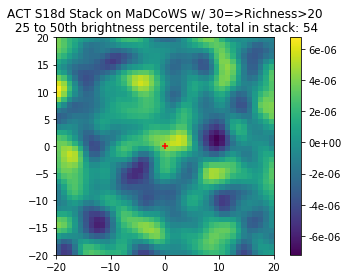

[  4  11  13  28  33  39  43  53  59  61  64  73  77  81  84  85  87  90
  91  94 102 107 111 113 115 123 130 134 136 137 144 145 151 155 156 157
 159 161 166 167 171 178 180 184 187 195 197 200 202 207 209 210 216 217
 225 230 238 243 253 255 265 266 268 270 275 277 287 291 298 302 303 313
 319 322 324 326 331 332 338 340 341 342 348 354 356 357 363 364 365 366
 367 368 374]
Number in stack: 58


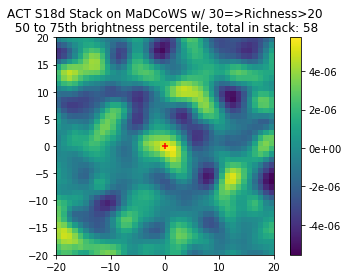

[  1   3   8  10  17  20  21  30  38  42  47  60  66  70  76  83  86  89
  95  96  98 101 104 108 109 110 112 114 118 121 125 129 133 135 138 140
 143 146 147 149 150 152 153 163 165 170 172 176 181 186 188 189 192 193
 198 211 213 215 220 222 244 247 256 263 273 283 285 286 288 289 292 294
 300 301 304 305 306 307 314 316 317 320 327 328 330 337 344 351 353 358
 359 360 361 362]
Number in stack: 60


KeyboardInterrupt: 

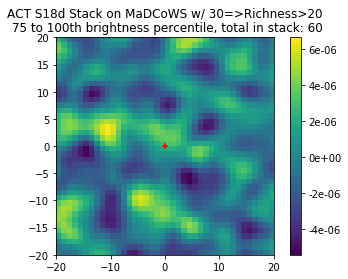

In [238]:
long_means2 =[]
for i in range(0, 60, 10):
    mean = richStatBright(s18d, mdcw_catalog, i, i+10, bins = 4)
    long_means2.append(mean)

[[array(-1.1075469898792284e-05), array(7.898660561309735e-07), array(6.315757497037213e-06), array(1.6253378481695032e-05)], [array(9.678409044032825e-06), array(2.202665772779242e-06), array(1.6075942266397018e-06), array(8.760480672968177e-06)], [array(5.32723022744044e-06), array(5.4777219470250325e-06), array(5.751415139462301e-06), array(3.861690319974485e-06)], [array(9.706041586896573e-06), array(4.239865161963486e-06), array(4.668549980797177e-06), array(1.2942873578259832e-05)], [array(2.162157119893218e-05), array(2.9671595587786356e-05), array(2.3416565419841753e-05), array(2.7720108748686013e-05)], [array(8.236540969721195e-05), array(2.5132016191272003e-05), array(6.533163519566397e-05), array(1.6809900542871e-05)]]


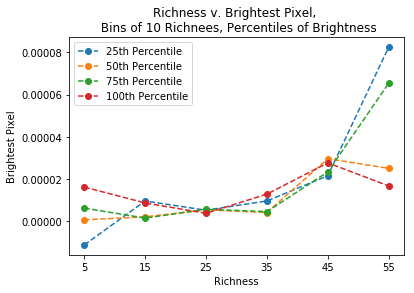

In [229]:
print(long_means2)
temp2 = np.transpose(long_means2)
for i in range(len(temp)):
    plt.plot( range(5,65, 10),temp2[i], label = str(int((i+1)*100/(len(temp))))+'th Percentile', marker='o',linestyle="dashed")
plt.legend()
plt.xlabel('Richness')
plt.xticks(range(5, 65, 10))
plt.ylabel('Brightest Pixel')
plt.title('Richness v. Brightest Pixel, \n Bins of 10 Richnees, Percentiles of Brightness')
plt.savefig('richness-brightness2.png')
plt.show()

In [223]:
print(long_means)
print(long_means2)

[[array(4.639209634935144e-06), array(1.6727383830492167e-06), array(-8.228990699033303e-07), array(-2.3653964082122795e-06)], [array(2.6756976962237194e-06), array(5.151087501285133e-06), array(1.4742184271573919e-06), array(-4.532102305040394e-06)], [array(2.6046727585354933e-06), array(6.334985329353516e-06), array(4.330614608354858e-06), array(5.048076655095735e-06)], [array(3.217149331019145e-06), array(1.2580892691219908e-05), array(1.1011060888529624e-05), array(1.2836922458461913e-05)], [array(2.1498686846238772e-05), array(2.8145322416831832e-05), array(3.776780735394813e-05), array(4.548075932238993e-05)], [array(3.769323040277112e-05), array(8.249357149459505e-05), array(1.4604049983767147e-05), array(0.00011190804222377785)]]
[[array(4.639209634935144e-06), array(1.6727383830492167e-06), array(-8.228990699033303e-07), array(-2.3653964082122795e-06)], [array(2.6756976962237194e-06), array(5.151087501285133e-06), array(1.4742184271573919e-06), array(-4.532102305040394e-06)], 